<a href="https://colab.research.google.com/github/sahilbaishya/Customer_Segmentation_Analysis/blob/main/rfm_custormerSegmentationAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd
import numpy as np
import time
import datetime as dt


In [96]:
import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [97]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')

start = time.time()

# Data Loading

In [98]:
!pip install -q kaggle

In [99]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [100]:
!chmod 600 /root/.kaggle/kaggle.json

In [101]:
!kaggle datasets download -d mashlyn/online-retail-ii-uci

online-retail-ii-uci.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/online-retail-ii-uci.zip" -d "/content/dataset"

Archive:  /content/online-retail-ii-uci.zip
replace /content/dataset/online_retail_II.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [103]:
df = pd.read_csv("/content/dataset/online_retail_II.csv", encoding='unicode_escape', dtype= {'CustomerID': str})

# Data Exploration

In [104]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [105]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [106]:
df.shape

(1067371, 8)

In [107]:
df.rename(index=str,
          columns = {
              'Invoice': 'invoice',
              'StockCode': 'stock_code',
              'Description': 'description',
              'Quantity': 'quantity',
              'InvoiceDate': 'invoice_date',
              'Price': 'price',
              'Customer ID': 'customer_id',
              'Country': 'country'

          }, inplace = True)

# Data Cleaning

In [108]:
df.isnull().values.any()

True

In [109]:
df.isnull().sum()

invoice              0
stock_code           0
description       4382
quantity             0
invoice_date         0
price                0
customer_id     243007
country              0
dtype: int64

In [110]:
# % missing Data
missing_percentage = (( df.isnull().sum() / df.shape[0] ) * 100).round(2)
missing_percentage

invoice          0.00
stock_code       0.00
description      0.41
quantity         0.00
invoice_date     0.00
price            0.00
customer_id     22.77
country          0.00
dtype: float64

In [111]:
#dropping rows with missing values
df.dropna(inplace=True)


In [112]:
df.isnull().sum()

invoice         0
stock_code      0
description     0
quantity        0
invoice_date    0
price           0
customer_id     0
country         0
dtype: int64

In [113]:
duplicateRows = df[df.duplicated()].value_counts().sum()
duplicateRows

26479

In [114]:
#dropping duplicate rows

df.drop_duplicates(inplace=True, keep = 'first')

In [115]:
duplicateRowsAfter = df[df.duplicated()].value_counts().sum()
duplicateRowsAfter

0

In [116]:
df.shape

(797885, 8)

In [117]:
df['invoice_date'].head()

0    2009-12-01 07:45:00
1    2009-12-01 07:45:00
2    2009-12-01 07:45:00
3    2009-12-01 07:45:00
4    2009-12-01 07:45:00
Name: invoice_date, dtype: object

In [118]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['invoice_date'].head()

0   2009-12-01 07:45:00
1   2009-12-01 07:45:00
2   2009-12-01 07:45:00
3   2009-12-01 07:45:00
4   2009-12-01 07:45:00
Name: invoice_date, dtype: datetime64[ns]

In [119]:
print('Datafile starts at', df['invoice_date'].min())
print('Datafile ends at', df['invoice_date'].max())

Datafile starts at 2009-12-01 07:45:00
Datafile ends at 2011-12-09 12:50:00


In [120]:
df.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
price                  float64
customer_id            float64
country                 object
dtype: object

# Exploring the data deeper


In [121]:
#countries

df['country'].value_counts().reset_index()

,index,country
0,United Kingdom,716115
1,Germany,17339
2,EIRE,16014
3,France,13897
4,Netherlands,5137
5,Spain,3754
6,Belgium,3110
7,Switzerland,3058
8,Portugal,2414
9,Australia,1890


In [122]:
country_df = df[['country', 'customer_id']]
country_df.groupby(['country']).agg({'customer_id': 'count'}).sort_values('customer_id', ascending = False).reset_index()

,country,customer_id
0,United Kingdom,716115
1,Germany,17339
2,EIRE,16014
3,France,13897
4,Netherlands,5137
5,Spain,3754
6,Belgium,3110
7,Switzerland,3058
8,Portugal,2414
9,Australia,1890


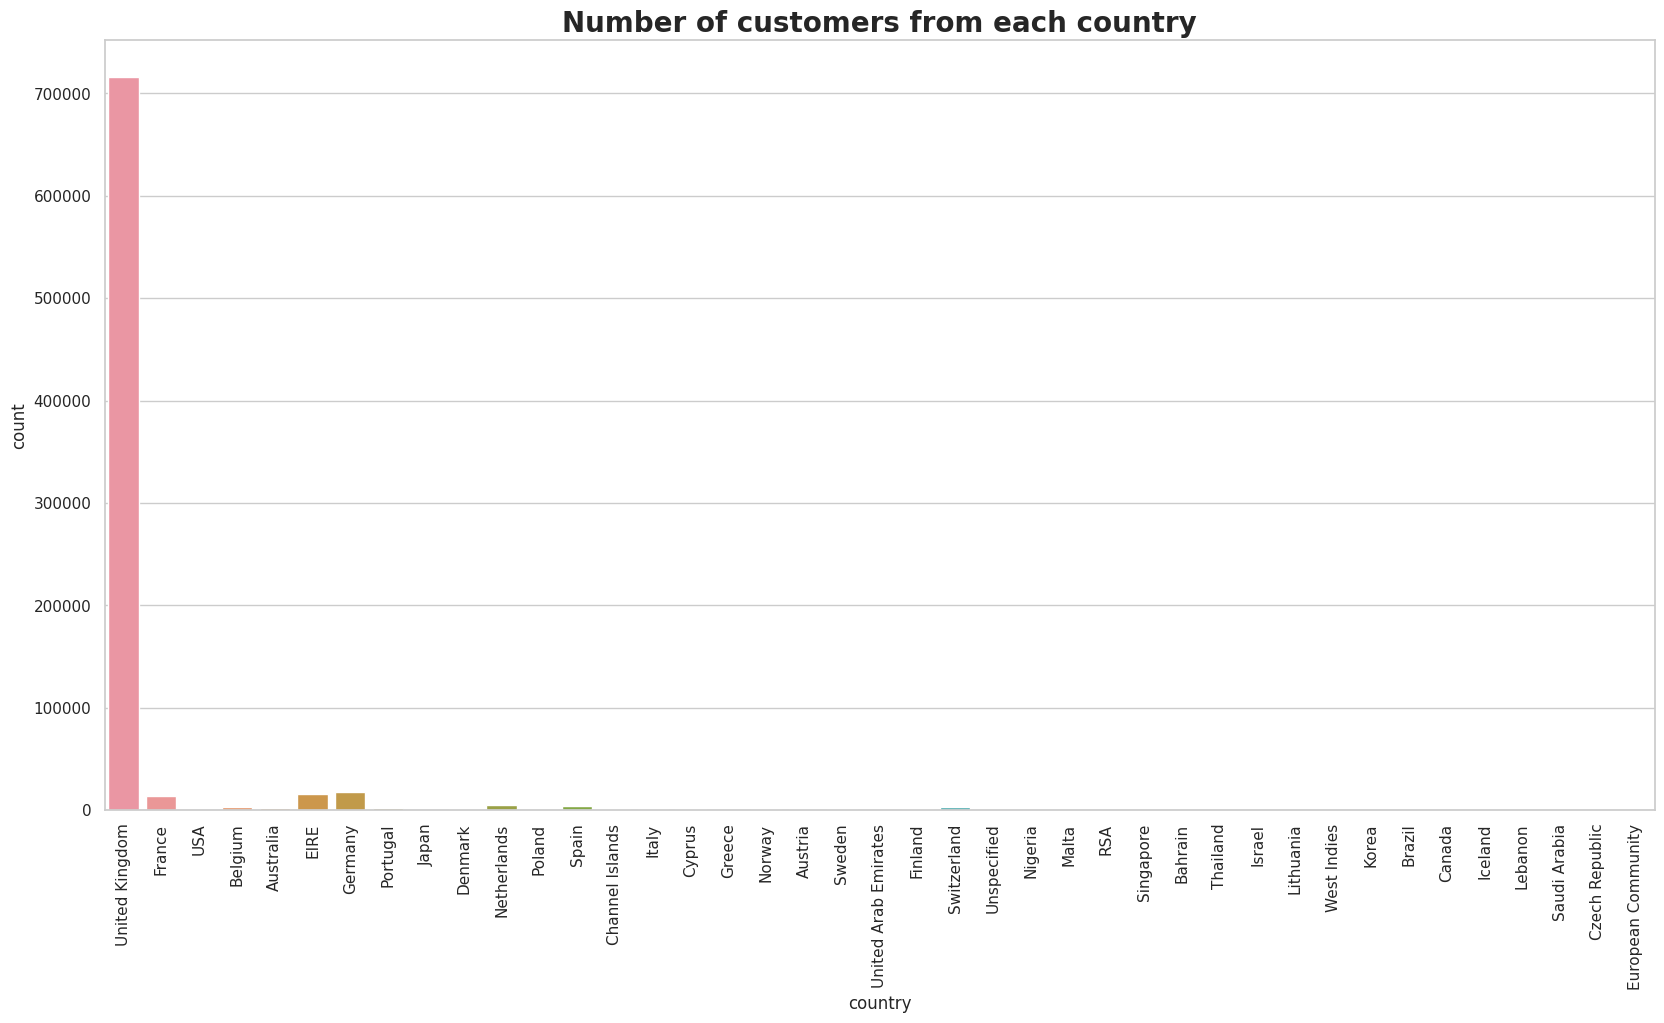

In [123]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig = plt.subplots(figsize=(20, 10))

#plot count of each RFM segment
sns.countplot(x="country", data=country_df).set_title('Number of customers from each country', weight = 'bold').set_fontsize('20')
plt.xticks(rotation=90)

plt.show()


In [124]:
df.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'price', 'customer_id', 'country'],
      dtype='object')

In [125]:
#Number of orders from each country
invoice_df = df[['invoice', 'country']].groupby('country').agg({'invoice': 'count'}).sort_values('invoice', ascending= False).reset_index()
invoice_df

,country,invoice
0,United Kingdom,716115
1,Germany,17339
2,EIRE,16014
3,France,13897
4,Netherlands,5137
5,Spain,3754
6,Belgium,3110
7,Switzerland,3058
8,Portugal,2414
9,Australia,1890


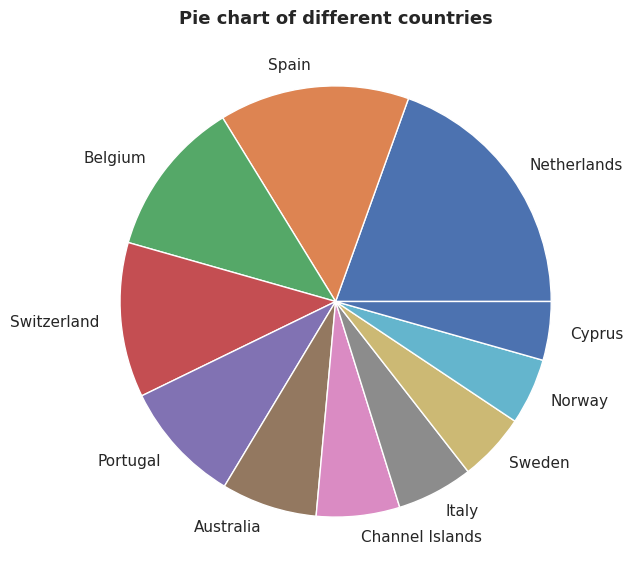

In [126]:
# Creating a Pie Chart to Visualize the the data better

# Creating dataset
country = invoice_df['country'][4: 15]
invoice = invoice_df['invoice'][4: 15]

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(invoice, labels = country)

# Set a title
plt.title('Pie chart of different countries', weight = 'bold').set_fontsize('13')

# show plot
plt.show()

In [127]:
df.describe().round(2)

,quantity,price,customer_id
count,797885.00,797885.00,797885.00
mean,12.60,3.70,15313.06
std,191.67,71.39,1696.47
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13964.00
50%,5.00,1.95,15228.00
75%,12.00,3.75,16788.00
max,80995.00,38970.00,18287.00


In [128]:
#No of unique values in each column
for col in df.columns:
    print(f'{col}: {df[col].nunique()} items')

invoice: 44876 items
stock_code: 4646 items
description: 5299 items
quantity: 643 items
invoice_date: 41439 items
price: 1022 items
customer_id: 5942 items
country: 41 items


In [129]:
df['stock_code'].value_counts().head(10)

85123A    5156
22423     3678
85099B    3380
84879     2709
20725     2686
21212     2582
21232     2122
47566     2121
20727     2089
22383     2070
Name: stock_code, dtype: int64

In [130]:
print('Top 5 selling items: \n')

most_stock_item = df.groupby('stock_code')['description'].value_counts().sort_values(ascending=False)
most_stock_item.head()

Top 5 selling items: 



stock_code  description                       
85123A      WHITE HANGING HEART T-LIGHT HOLDER    5149
22423       REGENCY CAKESTAND 3 TIER              3678
85099B      JUMBO BAG RED RETROSPOT               2713
84879       ASSORTED COLOUR BIRD ORNAMENT         2709
47566       PARTY BUNTING                         2121
Name: description, dtype: int64

In [131]:
print('Bottom 5 selling items: \n')

most_stock_item = df.groupby('stock_code')['description'].value_counts().sort_values(ascending=True)
most_stock_item.head()

Bottom 5 selling items: 



stock_code  description                    
TEST002     This is a test product.            1
84206B      CAT WITH SUNGLASSES BLANK CARD     1
21852       EMPIRE TEDDY                       1
84250M      GREETING CARD, BLACKPOOL ROCK      1
21838       DADDY MOUSE RED GINGHAM BOW TIE    1
Name: description, dtype: int64

In [132]:
print('Most wanted items in the dataset are \n')

df.groupby('description')['quantity'].sum().sort_values(ascending = False).head(20).astype(int)

Most wanted items in the dataset are 



description
WORLD WAR 2 GLIDERS ASSTD DESIGNS      103505
WHITE HANGING HEART T-LIGHT HOLDER      88126
ASSORTED COLOUR BIRD ORNAMENT           77755
JUMBO BAG RED RETROSPOT                 73033
BROCADE RING PURSE                      69343
PACK OF 60 PINK PAISLEY CAKE CASES      54373
60 TEATIME FAIRY CAKE CASES             52502
PACK OF 72 RETRO SPOT CAKE CASES        44480
PACK OF 72 RETROSPOT CAKE CASES         44356
SMALL POPCORN HOLDER                    42592
MINI PAINT SET VINTAGE                  41226
ASSORTED COLOURS SILK FAN               40077
COLOUR GLASS T-LIGHT HOLDER HANGING     38537
PACK OF 72 SKULL CAKE CASES             38441
PACK OF 12 LONDON TISSUES               37012
VICTORIAN GLASS HANGING T-LIGHT         36278
JUMBO BAG STRAWBERRY                    35559
RED  HARMONICA IN BOX                   34349
72 SWEETHEART FAIRY CAKE CASES          33526
STRAWBERRY CERAMIC TRINKET BOX          33117
Name: quantity, dtype: int64

In [133]:
print('Most wanted items in the dataset are \n')

df.groupby('description')['quantity'].sum().sort_values(ascending = False).tail(20).astype(int)

Most wanted items in the dataset are 



description
ENGLISH ROSE DESIGN KITCHEN APRON        -2
VINTAGE WOOD ORGANISER                   -2
S/4 HEART CRYSTAL FRIDGE MAGNETS         -3
Adjustment by Peter on 24/05/2010 1      -3
CREAM SWEETHEART DOUBLE SHELF            -3
HAND OPEN SHAPE CHROME                   -3
PINK EAR MUFF HEADPHONES                 -3
SET OF KITCHEN WALL  STICKERS            -4
LARGE GLASS HEART TRINKET POT            -4
WHITE ORCHID FLOWER LIGHTS               -6
FEATHER HEART LIGHTS                     -8
BLACK CHERRY LIGHTS                      -9
VINTAGE BLUE VACUUM FLASK 0.5L          -10
WHITE SCANDINAVIAN HEART CHRISTMAS      -11
SET 6 MINI SUSHI SET FRIDGE MAGNETS     -12
CRUK Commission                         -16
TREE OF NOAH FESTIVE SCENTED CANDLE     -46
SILVER CHERRY LIGHTS                    -93
WHITE CHERRY LIGHTS                    -105
Discount                              -2865
Name: quantity, dtype: int64

In [134]:
# View all the stock code of the dataset

list_special_codes = df[df['stock_code'].str.contains('^[a-zA-Z]+', regex=True)]['stock_code'].unique()
list_special_codes

array(['POST', 'D', 'M', 'C2', 'BANK CHARGES', 'TEST001', 'TEST002',
       'PADS', 'ADJUST', 'ADJUST2', 'SP1002', 'DOT', 'CRUK'], dtype=object)

In [135]:
for code in list_special_codes:
    print("{:<15} ->  {:<30}".format(code, df[df['stock_code'] == code]['description'].unique()[0]))

POST            ->  POSTAGE                       
D               ->  Discount                      
M               ->  Manual                        
C2              ->  CARRIAGE                      
BANK CHARGES    ->   Bank Charges                 
TEST001         ->  This is a test product.       
TEST002         ->  This is a test product.       
PADS            ->  PADS TO MATCH ALL CUSHIONS    
ADJUST          ->  Adjustment by john on 26/01/2010 16
ADJUST2         ->  Adjustment by Peter on Jun 25 2010 
SP1002          ->  KID'S CHALKBOARD/EASEL        
DOT             ->  DOTCOM POSTAGE                
CRUK            ->  CRUK Commission               


# Order Details

In [136]:
canceled = (df["invoice"].str.contains("C", na=False)).sum()

print('Cancelled items: ', canceled)

Cancelled items:  18390


In [137]:
per_canceled = ((canceled / df.shape[0]) * 100 ).round(2)

print('Percentage Orders Cancelled:',per_canceled , '%')

Percentage Orders Cancelled: 2.3 %


In [138]:
flag = False
if (df['quantity'] < 0).any():
    flag = True
    print(flag)

True


In [139]:
df['canceled'] = df['invoice'].apply(lambda x : 'Yes' if x[0] == 'C' else 'No')

In [140]:
negative_quantity = df[df['quantity'] < 0]
negative_quantity.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,canceled
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,Yes
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,Yes
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,Yes
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,Yes
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,Yes


In [141]:
print('The cancelled items: ',negative_quantity.value_counts().sum() )

The cancelled items:  18390


In [142]:

df = df[df['quantity'] > 0]
df.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,canceled
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,No
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,No
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,No
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,No
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,No


In [143]:
df.shape

(779495, 9)

# RFM (Recency, Frequency, Monetary) Calculation

In [144]:
df.columns

Index(['invoice', 'stock_code', 'description', 'quantity', 'invoice_date',
       'price', 'customer_id', 'country', 'canceled'],
      dtype='object')

In [145]:
df["total_price"] = df["quantity"] * df["price"]

<ipython-input-145-c10e88956d31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["total_price"] = df["quantity"] * df["price"]


In [146]:
df.sort_values('total_price', ascending=False).head().reset_index()

,index,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,canceled,total_price
0,1065882,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,No,168469.6
1,587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,No,77183.6
2,748132,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,No,38970.0
3,432176,530715,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9360,2010-11-04 11:36:00,1.69,15838.0,United Kingdom,No,15818.4
4,135013,502263,M,Manual,1,2010-03-23 15:22:00,10953.50,12918.0,United Kingdom,No,10953.5


In [147]:
#No. of products sold by Country

products_country = df.groupby('country').count()['total_price'].sort_values(ascending=False).head(10)
products_country

country
United Kingdom    700434
Germany            16440
EIRE               15567
France             13512
Netherlands         5090
Spain               3663
Belgium             3056
Switzerland         3006
Portugal            2356
Australia           1792
Name: total_price, dtype: int64

In [148]:
products_country = df.groupby('country').count()['total_price'].sort_values(ascending=False).tail(10)
products_country

country
Brazil                94
Thailand              76
European Community    60
Bahrain               59
West Indies           54
Korea                 53
Lebanon               45
Nigeria               30
Czech Republic        25
Saudi Arabia           9
Name: total_price, dtype: int64

In [149]:
present = dt.date(2011,12,9)

# RFM Table

In [150]:
today_date = dt.datetime(2011,12,11)

In [151]:
rfm = df.groupby('customer_id').agg({'invoice_date' : lambda invoice_date:  (today_date - invoice_date.max()).days,
                                    'invoice'   : lambda invoice:   invoice.nunique(),
                                    'total_price'   : lambda total_price:   total_price.sum()})

In [152]:
rfm.shape

(5881, 3)

In [153]:
rfm.columns = ['recency','frequency','monetary']
rfm['monetary']= rfm[rfm['monetary'] > 0]['monetary']
rfm = rfm.reset_index()
rfm.head()

,customer_id,recency,frequency,monetary
0,12346.0,326,12,77556.46
1,12347.0,3,8,4921.53
2,12348.0,76,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,311,1,334.40


In [ ]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig, ax = plt.subplots(figsize=(13, 13))

rfm.boxplot(grid=False, rot=45, fontsize=15)

In [155]:
rfm.sort_values(['frequency', 'monetary'], ascending=[False, False], inplace=True)
rfm.head()

,customer_id,recency,frequency,monetary
2541,14911.0,2,398,291420.81
400,12748.0,1,337,53539.64
5436,17841.0,2,211,68545.25
2938,15311.0,1,208,114966.42
739,13089.0,3,203,113416.91


In [156]:
rfm_new = rfm.copy()

In [157]:
rfm['recency_score'] = pd.qcut(rfm['recency'] , 5 , labels = range(1,6,1))

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels =range(1, 6, 1) )

rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels= range(1, 6, 1))

rfm['RFM_Score'] = rfm[['recency_score', 'frequency_score', 'monetary_score']].sum(axis=1).astype(int)

rfm['RFM_Segmentantion'] = (rfm['recency_score'].astype(str)
                            + rfm['frequency_score'].astype(str)
                            + rfm['monetary_score'].astype(str))

In [158]:
rfm.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,RFM_Segmentantion
2541,14911.0,2,398,291420.81,1,5,5,11,155
400,12748.0,1,337,53539.64,1,5,5,11,155
5436,17841.0,2,211,68545.25,1,5,5,11,155
2938,15311.0,1,208,114966.42,1,5,5,11,155
739,13089.0,3,203,113416.91,1,5,5,11,155


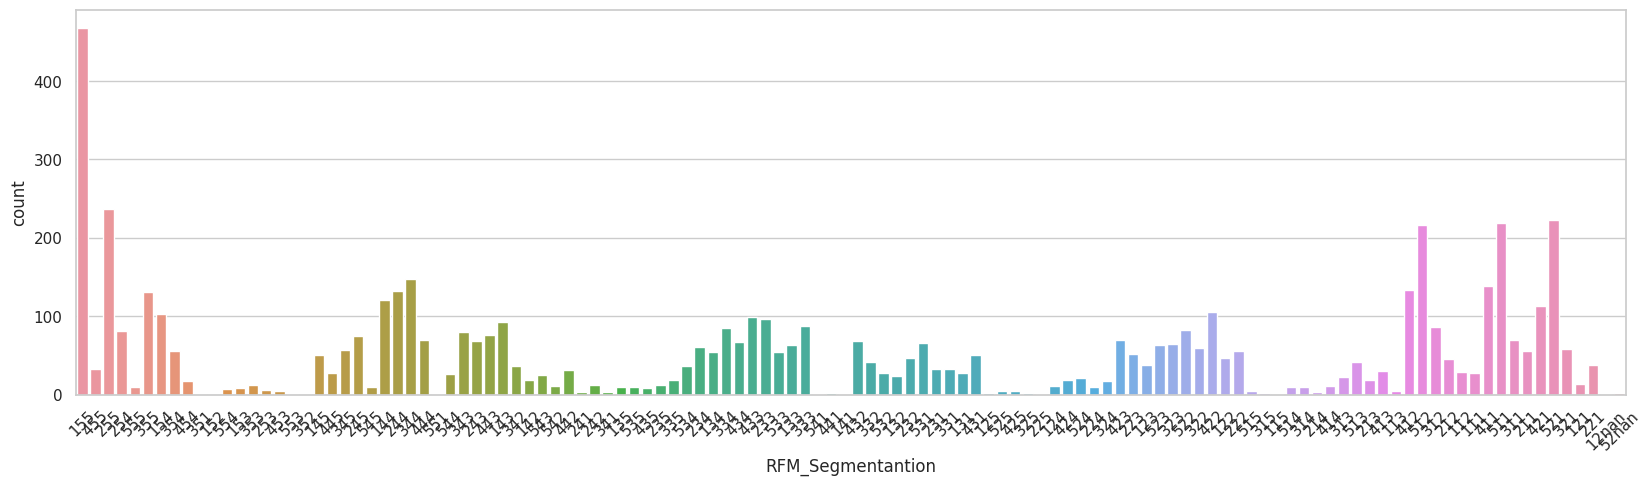

In [159]:


#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig, ax = plt.subplots(figsize=(20, 5))

#plot count of each RFM segment
sns.countplot(x="RFM_Segmentantion", data=rfm)
plt.xticks(rotation=45)

plt.show()



In [160]:
# Create a new column accordingly to the customers score

def rank(a):

    if  (a >= 0) & (a <= 3):
        return 'Basic'

    elif (a <=7):
        return 'Advanced'

    elif (a <= 13):
        return 'Gold'
    else:
        return 'Platinum'

In [161]:
rfm['Rank_id'] = rfm['RFM_Score'].apply(rank)
rfm.head(10).reset_index()

,index,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,RFM_Segmentantion,Rank_id
0,2541,14911.0,2,398,291420.81,1,5,5,11,155,Gold
1,400,12748.0,1,337,53539.64,1,5,5,11,155,Gold
2,5436,17841.0,2,211,68545.25,1,5,5,11,155,Gold
3,2938,15311.0,1,208,114966.42,1,5,5,11,155,Gold
4,739,13089.0,3,203,113416.91,1,5,5,11,155,Gold
5,2239,14606.0,2,192,29951.37,1,5,5,11,155,Gold
6,1791,14156.0,10,156,313437.62,1,5,5,11,155,Gold
7,5445,17850.0,373,155,51208.87,4,5,5,14,455,Platinum
8,2279,14646.0,2,152,528602.52,1,5,5,11,155,Gold
9,5695,18102.0,1,145,580987.04,1,5,5,11,155,Gold


In [162]:
# We can underastand better the clients by the rank

ranks = rfm['Rank_id'].value_counts()
ranks

Gold        4234
Advanced    1560
Platinum      58
Basic         29
Name: Rank_id, dtype: int64

In [163]:
rfm_new = rfm_new.drop(['customer_id'], axis = 1)
rfm_new.head()

,recency,frequency,monetary
2541,2,398,291420.81
400,1,337,53539.64
5436,2,211,68545.25
2938,1,208,114966.42
739,3,203,113416.91


In [164]:
rfm_new.dropna(inplace = True)
rfm_new.isnull().sum()

recency      0
frequency    0
monetary     0
dtype: int64

In [165]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_new)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [166]:
kmeans.labels_

array([2, 3, 3, ..., 0, 0, 0], dtype=int32)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

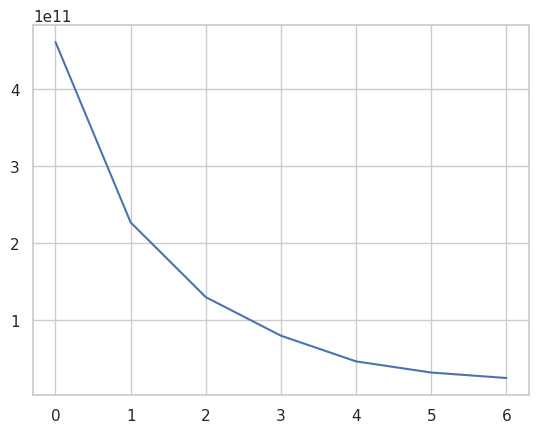

In [167]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_new)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

In [168]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_new)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_new, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.9868195611328601


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.9766128569257805


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.9161455980272774


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.8424332434738668


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.8306205661306922


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.7596122465746955


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.7609591295276514


In [169]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_new)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [170]:
# assign the label
rfm_new['Cluster_Id'] = kmeans.labels_
rfm_new.head()

,recency,frequency,monetary,Cluster_Id
2541,2,398,291420.81,2
400,1,337,53539.64,0
5436,2,211,68545.25,0
2938,1,208,114966.42,2
739,3,203,113416.91,2


In [171]:
end = time.time()
time = end - start
time1 = round(time, 2)
print('The project executed only in', time1 , 'seconds')

The project executed only in 227.86 seconds
